In [1]:
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import IPython
import gc
import torch.nn.functional as F
import torchaudio.transforms as tt
import matplotlib
import matplotlib.pyplot as plt
import wandb
import random
import torch.optim as optim
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections

%matplotlib inline

In [ ]:
# Antes de los experimentos
os.environ['WANDB_REPOSITORY'] = "TP3_TD6"
os.environ['WANDB_BRANCH'] = "main"

wandb.login(key = os.environ["WANDB_API_KEY"])

### Funciones

In [3]:
# Parseo de géneros
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

# Obtener clases
def classes(root = '/genres_5sec'):
    list_files=os.listdir(root)
    classes=[]
    for file in list_files:
        name='{}/{}'.format(root,file)
        if os.path.isdir(name):
            classes.append(file)
    return classes

# Plotear waveforms
def plot_waveforms(dataset, num_samples=5, figsize=(15, 10)):
    """
    Plotea múltiples waveforms con sus etiquetas correspondientes.
    
    Args:
        dataset: Dataset que contiene los audios y etiquetas
        num_samples: Número de waveforms a mostrar
        figsize: Tamaño de la figura (ancho, alto)
    """
    
    fig, axes = plt.subplots(num_samples, 1, figsize=figsize)
    fig.suptitle('Waveforms de diferentes géneros musicales', fontsize=16)
    
    # Asegurarse de que axes sea siempre una lista
    if num_samples == 1:
        axes = [axes]
    
    # Obtener índices aleatorios sin repetición
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx, ax in zip(indices, axes):
        waveform, label = dataset[idx]
        genre = dataset.classes[label]
        
        # Plotear la waveform
        ax.plot(waveform.t().numpy()[0], linewidth=1)
        ax.set_title(f'Género: {genre}')
        ax.set_xlabel('Tiempo (muestras)')
        ax.set_ylabel('Amplitud')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Para comparar waveforms del mismo género
def plot_genre_waveforms(dataset, genre_name, num_samples=3, figsize=(15, 8)):
    """
    Plotea múltiples waveforms del mismo género.
    
    Args:
        dataset: Dataset que contiene los audios y etiquetas
        genre_name: Nombre del género a visualizar
        num_samples: Número de waveforms a mostrar
        figsize: Tamaño de la figura (ancho, alto)
    """
    
    genre_idx = dataset.classes.index(genre_name)
    genre_samples = [(i, wave, label) for i, (wave, label) in enumerate(dataset) if label == genre_idx]
    
    if len(genre_samples) < num_samples:
        num_samples = len(genre_samples)
    
    selected_samples = random.sample(genre_samples, num_samples)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=figsize)
    fig.suptitle(f'Waveforms del género: {genre_name}', fontsize=16)
    
    if num_samples == 1:
        axes = [axes]
    
    for i, (idx, waveform, _) in enumerate(selected_samples):
        axes[i].plot(waveform.t().numpy()[0], linewidth=1)
        axes[i].set_title(f'Muestra {idx}')
        axes[i].set_xlabel('Tiempo (muestras)')
        axes[i].set_ylabel('Amplitud')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Stratify split
def stratify_split(dataset: Dataset, classes: list[int]) -> tuple[Subset, Subset, Subset]:
    
    train_indices = []
    val_indices = []
    test_indices = []

    NUM_CLASSES = len(classes)
    total_samples = len(dataset)
    
    # Calcular el número de muestras para cada conjunto
    train_samples = int(total_samples * 0.8)
    val_samples = int(total_samples * 0.1)
    test_samples = total_samples - train_samples - val_samples  # Resto para test

    train_samples_per_class = train_samples // NUM_CLASSES
    val_samples_per_class = val_samples // NUM_CLASSES
    test_samples_per_class = test_samples // NUM_CLASSES

    train_target_counter = collections.Counter()
    val_target_counter = collections.Counter()
    test_target_counter = collections.Counter()

    for idx, data in enumerate(dataset):
        target = data[1]
        if train_target_counter[target] < train_samples_per_class:
            train_indices.append(idx)
            train_target_counter[target] += 1
        elif val_target_counter[target] < val_samples_per_class:
            val_target_counter[target] += 1
            val_indices.append(idx)
        elif test_target_counter[target] < test_samples_per_class:
            test_target_counter[target] += 1
            test_indices.append(idx)

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Clases

In [68]:
# Normalización de audio
class NormalizeAudio(nn.Module):
    def __init__(self, mean=0.0, std=1.0):
        super(NormalizeAudio, self).__init__()
        self.mean = mean
        self.std = std

    def forward(self, waveform):
        return (waveform - self.mean) / self.std

# Dataset
class MusicDataset(Dataset):
    def __init__(self, root = '/genres_5sec', transform=None):
        super().__init__()
        self.root = root
        self.files = []
        classes = self.get_classes(self.root)
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        self.transform = transform 

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]

        if self.transform:  # Aplica el transform si existe
            audio = self.transform(audio)

        return audio, class_idx
    
    def get_classes(self, root):
        list_files=os.listdir(root)
        classes=[]
        for file in list_files:
            name='{}/{}'.format(root,file)
            if os.path.isdir(name):
                classes.append(file)
        return classes
    

# Modelo
class MLP(nn.Module):
    def __init__(self, n_input, nodes=128, n_output=10, dropout_prob=0.3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_input, nodes)
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, n_output)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplanar la entrada
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

# TP3: Encodeador de música

In [33]:
dataset = MusicDataset()

### **Creación de los conjuntos**

In [40]:
# Definir el sample rate
samplerate = 22050

# Transformaciones para entrenamiento
train_transform = nn.Sequential(
    NormalizeAudio(mean=0.0, std=1.0),
    
    # Aumentación de datos (solo para entrenamiento)
    torchaudio.transforms.TimeStretch(n_freq=128),
    torchaudio.transforms.PitchShift(sample_rate=samplerate, n_steps=2),
    
    # Transformación a espectrograma
    torchaudio.transforms.MelSpectrogram(
        sample_rate=samplerate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ),
    
    # Convertir a decibeles
    torchaudio.transforms.AmplitudeToDB()
)

# Transformaciones para validación y prueba
val_test_transform = nn.Sequential(
    NormalizeAudio(mean=0.0, std=1.0),
    
    torchaudio.transforms.MelSpectrogram(
        sample_rate=samplerate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ),
    torchaudio.transforms.AmplitudeToDB()
)


/Users/lucamazzarello_/opt/anaconda3/envs/TDVI/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [42]:
random_seed = 43992294
batch_size = 20

torch.manual_seed(random_seed);

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

In [43]:
# Dividir el dataset usando dataset.classes en lugar de la función classes
train_dataset, val_dataset, test_dataset = stratify_split(dataset, dataset.classes)

train_dataset.transform = train_transform
val_dataset.transform = val_test_transform
test_dataset.transform = val_test_transform

# Crear los dataloaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size)
testloader = DataLoader(test_dataset, batch_size=batch_size)

In [51]:
len(trainloader), len(valloader), len(testloader)

(40, 5, 5)

In [52]:
len(train_dataset), len(val_dataset), len(test_dataset)

(790, 90, 90)

### Visualización de los archivos

In [63]:
# waveform,label= train_dataset[789]
# print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

waveform,label= val_dataset[60]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

# waveform,label= test_dataset[70]
# print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))


shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 4 


shape of spectogram torch.Size([1, 201, 552])


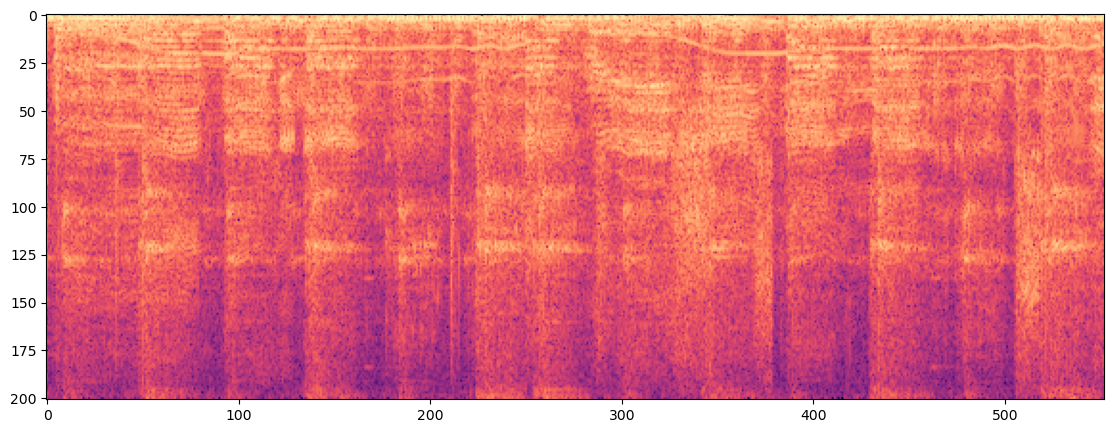

In [64]:
specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')

Waveform: tensor([[-0.0007, -0.0401, -0.0155,  ...,  0.0028,  0.0907,  0.1127]])



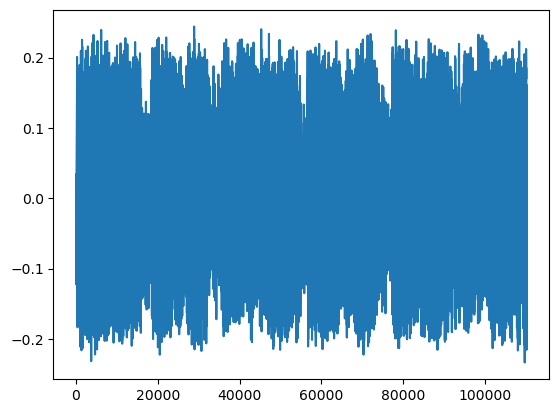

In [65]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

In [ ]:
IPython.display.Audio(waveform,rate=samplerate)

In [66]:
specgram.size()

torch.Size([1, 201, 552])

### Clasificación

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 
                      'cpu')

In [70]:
n_input = 110250

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
gc.collect()  # Importante para liberar memoria RAM

best_valid_loss = float('inf')
worst_valid_loss = float('-inf')
best_experiment = None
worst_experiment = None
num_epochs = 100

# Definir loss function
loss_function = nn.CrossEntropyLoss()

# Define a list of hyperparameter configurations
hyperparameter_configs = [
    # Configuraciones con learning rate bajo
    {"learning_rate": 0.001, "batch_size": 64, "nodes": 128},
    {"learning_rate": 0.0005, "batch_size": 32, "nodes": 256},
    {"learning_rate": 0.001, "batch_size": 16, "nodes": 128},
]

for config in hyperparameter_configs:
    
    # Generar nombre del experimento
    experiment_name = f"lr_{config['learning_rate']}_nodes_{config['nodes']}"

    wandb.init(
        project='Trabajo_Practico_3_Music_Genre_Classification',
        name=experiment_name,
        reinit = True,
        save_code=True,
        config={
            "architecture": "MLP",
            "dataset": "GTZAN",
            "num_classes": len(dataset.classes),
            "classes": dataset.classes,
            "sample_rate": samplerate,
            "input_size": n_input
            }
    )
    
    # Inicializar modelo y optimizador con la configuración actual
    model = MLP(n_input=n_input, 
                nodes=config['nodes'],
                n_output=len(dataset.classes)).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    print(f"\nStarting experiment: {experiment_name}")
    print(model)
    print(f"Number of parameters: {count_parameters(model)}")
    
    # Bucle de entrenamiento
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        
        for wav, genre_index in trainloader:
            wav = wav.to(device)
            genre_index = genre_index.to(device)
            
            optimizer.zero_grad()
            out = model(wav.view(wav.size(0), -1))  # Aplanar el input
            loss = loss_function(out, genre_index)
            
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validación
        model.eval()
        valid_losses = []
        correct = 0
        total = 0
        
        with torch.no_grad():
            for wav, genre_index in valloader:
                wav = wav.to(device)
                genre_index = genre_index.to(device)
                
                out = model(wav.view(wav.size(0), -1))
                loss = loss_function(out, genre_index)
                valid_losses.append(loss.item())
                
                _, predicted = torch.max(out.data, 1)
                total += genre_index.size(0)
                correct += (predicted == genre_index).sum().item()
        
        train_loss = np.mean(train_losses)
        valid_loss = np.mean(valid_losses)
        accuracy = correct / total
        
        # Logging
        wandb.log({
            "train_loss": train_loss,
            "valid_loss": valid_loss,
            "accuracy": accuracy,
            "epoch": epoch
        })
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, '
              f'Valid Loss: {valid_loss:.4f}, '
              f'Accuracy: {accuracy:.4f}')
        
        # Actualizar scheduler
        scheduler.step(valid_loss)
        
        if not os.path.exists('best_models'):
            os.makedirs('best_models')

        # Luego modificar la línea de guardado
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_experiment = config
            torch.save(model.state_dict(), f'best_models/{experiment_name}.pt')
            print(f'Saved best model at epoch {epoch+1}')

    # Finalizar wandb
    wandb.finish()